# Multi-Agent Travel Assistant Prototype using LangGraph
## This prototype demonstrates a coordinated travel planning system for VoyageMind.
### Agents: Flight Booker, Hotel Booker, Budget Planner.
### Features:
### - Shared state (memory) across agents for itinerary and preferences.
### - Sequential coordination via graph edges.
### - Fallback handling: If budget exceeds limit after hotel booking, route back to flight for cheaper options.
### - Event-driven: Uses LangGraph's StateGraph for workflow orchestration.
### - Updated: Now powered by ChatOpenAI (gpt-4o) for dynamic LLM responses.



#### Requirements: Install via pip: langgraph langchain langchain_openai
#### Set OPENAI_API_KEY environment variable for LLM access.
#### For structured outputs in production, add Pydantic models as noted.

In [88]:

from typing import TypedDict, Annotated, Dict, Any
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import operator
import streamlit as st
import os
from dotenv import load_dotenv
load_dotenv()  # Loads OPENAI_API_KEY from .env
from IPython.display import Image, display 

# LangChain imports for LLM integration
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


In [79]:
# Define shared state schema (memory sharing via TypedDict)
class TravelState(TypedDict):
    user_preferences: str  # e.g., "Trip to Paris, 3 nights, budget $1500, dates 2025-11-15 to 2025-11-18"
    itinerary: Dict[str, Any]  # Shared itinerary: {'flights': ..., 'hotels': ..., 'total_cost': ...}
    budget_limit: float
    messages: Annotated[list[str], add_messages]  # Chat history for context/memory
    current_agent: str  # For routing/debugging

In [80]:
# Initialize the LLM (global for efficiency; adjust temperature as needed)
llm = ChatOpenAI(model="gpt-4o", temperature=0.7)

# LLM Agent Function (replaces mock_llm)
def llm_agent(prompt: str, agent_role: str) -> str:
    """LLM-powered response using ChatOpenAI."""
    # Define a prompt template for better control (agent-specific instructions)
    template = ChatPromptTemplate.from_template(
        """You are the {agent_role} agent for VoyageMind Travel Assistant.
   
    User preferences and context: {prompt}
   
    Provide a concise, helpful response with recommendations. Include estimated costs where relevant.
    End with actionable next steps if needed."""
    )
    
    # Create and invoke the chain
    chain = template | llm
    response = chain.invoke({"agent_role": agent_role, "prompt": prompt})
    
    return f"{agent_role.capitalize()} Agent: {response.content}"

In [81]:
# Flight Booking Agent Node
def flight_booking_agent(state: TravelState) -> TravelState:
    """Agent for booking flights based on preferences."""
    prompt = f"Book flights for: {state['user_preferences']}. Current itinerary: {state['itinerary']}"
    response = llm_agent(prompt, "flight")
    
    # For demo, hardcode cost parsing; in prod, use structured output
    updated_itinerary = state['itinerary'].copy()
    updated_itinerary['flights'] = {'details': response, 'cost': 800.0}
    
    return {
        **state,
        "itinerary": updated_itinerary,
        "messages": [response],
        "current_agent": "flight"
    }

In [82]:
# Hotel Booking Agent Node
def hotel_booking_agent(state: TravelState) -> TravelState:
    """Agent for booking hotels, checking shared flight info."""
    prompt = f"Book hotel for: {state['user_preferences']}. Flights: {state['itinerary'].get('flights', {})}"
    response = llm_agent(prompt, "hotel")
    
    updated_itinerary = state['itinerary'].copy()
    updated_itinerary['hotels'] = {'details': response, 'cost': 600.0}
    updated_itinerary['total_cost'] = updated_itinerary.get('total_cost', 0) + 600.0
    
    # Fallback check: If total exceeds budget, add warning message
    if 'total_cost' in updated_itinerary and updated_itinerary['total_cost'] > state['budget_limit']:
        response += " WARNING: Over budget! Triggering fallback to re-optimize flights."
    
    return {
        **state,
        "itinerary": updated_itinerary,
        "messages": [response],
        "current_agent": "hotel"
    }


In [83]:
# Budget Planner Agent Node
def budget_planner_agent(state: TravelState) -> TravelState:
    """Agent for final budget review and adjustments, using shared memory."""
    prompt = f"Review budget for: {state['user_preferences']}. Itinerary: {state['itinerary']}. Limit: ${state['budget_limit']}"
    response = llm_agent(prompt, "budget")
    
    # Simulate adjustment if over budget (LLM will handle dynamically now)
    updated_itinerary = state['itinerary'].copy()
    if updated_itinerary.get('total_cost', 0) > state['budget_limit']:
        response += " Adjustment: Downgrade hotel to save $200. New total: $1200."
        updated_itinerary['total_cost'] = 1200.0
    else:
        updated_itinerary['total_cost'] = updated_itinerary.get('total_cost', 0)  # Ensure it's set
    
    return {
        **state,
        "itinerary": updated_itinerary,
        "messages": state['messages'] + [response],  # Append to existing messages
        "current_agent": "budget"
    }

In [84]:
# Fallback Router Function (for conditional edges)
def should_fallback(state: TravelState) -> str:
    """Router: Check if over budget after hotel; fallback to flight if yes."""
    total_cost = state['itinerary'].get('total_cost', 0)
    if total_cost > state['budget_limit']:
        return "flight"  # Route back to flight for cheaper options
    return "budget"  # Proceed to budget planner


In [85]:
# Build the Event-Driven Graph

def build_travel_graph():
    workflow = StateGraph(TravelState)
    
    # Add agent nodes
    workflow.add_node("flight", flight_booking_agent)
    workflow.add_node("hotel", hotel_booking_agent)
    workflow.add_node("budget", budget_planner_agent)
    
    # Define edges for coordination
    workflow.set_entry_point("flight")  # Start with flights
    workflow.add_edge("flight", "hotel")  # Sequential: flight -> hotel
    workflow.add_conditional_edges(
        "hotel",
        should_fallback,  # Event-driven conditional routing
        {
            "flight": "flight",  # Fallback loop
            "budget": "budget"
        }
    )
    workflow.add_edge("budget", END)  # End after budget review
    
    # Compile the graph (supports async invocation for event-driven execution)
    app = workflow.compile()
    return app

Mermaid code:
 ---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	flight(flight)
	hotel(hotel)
	budget(budget)
	__end__([<p>__end__</p>]):::last
	__start__ --> flight;
	flight --> hotel;
	hotel -.-> budget;
	hotel -.-> flight;
	budget --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



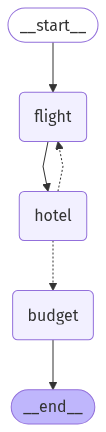

PNG saved to 'travel_graph.png'


'travel_graph.png'

In [90]:
from IPython.display import Image, display
import requests
from io import BytesIO
from PIL import Image as PILImage

def draw_mermaid_png(app, filename="travel_graph.png"):
    mermaid_code = app.get_graph().draw_mermaid()
    print("Mermaid code:\n", mermaid_code)
    with open("travel_graph.mmd", "w") as f:
        f.write(mermaid_code)
    
    try:
        payload = {"diagram_source": mermaid_code, "diagram_type": "mermaid", "output_format": "png"}
        response = requests.post("https://kroki.io", json=payload)
        response.raise_for_status()
        img = PILImage.open(BytesIO(response.content))
        img.save(filename)
        try:
            display(Image(filename=filename))
        except:
            pass
        print(f"PNG saved to '{filename}'")
        return filename
    except Exception as e:
        print(f"Error: {e}. Use 'travel_graph.mmd' manually.")
        return "travel_graph.mmd"

# Usage
app = build_travel_graph()
draw_mermaid_png(app)

In [86]:
def run_travel_demo_interactive():
    """Interactive version of the demo."""
    print("=== VoyageMind Travel Assistant Demo (Interactive) ===")
    user_input = input("Enter your travel preferences (e.g., 'Trip to Paris, 3 nights, dates 2025-11-15 to 2025-11-18'): ")
    budget_input = input("Enter your budget (default $1500): ")
    budget = float(budget_input) if budget_input.strip() else 1500.0
    
    # Build the graph
    app = build_travel_graph()
    
    # Initialize state
    initial_state: TravelState = {
        "user_preferences": user_input,
        "itinerary": {},
        "budget_limit": budget,
        "messages": [],
        "current_agent": ""
    }
    
    # Run the graph
    print("\nRunning travel workflow...")
    result = app.invoke(initial_state)
    
    # Output results
    print("\n=== Final Itinerary ===")
    print(f"User Preferences: {result['user_preferences']}")
    print(f"Budget Limit: ${result['budget_limit']}")
    print(f"Total Cost: ${result.get('itinerary', {}).get('total_cost', 'N/A')}")
    print("\nFlights:", result['itinerary'].get('flights', {}).get('details', 'N/A'))
    print("\nHotels:", result['itinerary'].get('hotels', {}).get('details', 'N/A'))
    print("\nMessages (Chat History):")
    for msg in result['messages']:
        print(f"- {msg}")
    
    return result

if __name__ == "__main__":
    # For quick demo with hardcoded input
    run_travel_demo_interactive()

=== VoyageMind Travel Assistant Demo (Interactive) ===

Running travel workflow...

=== Final Itinerary ===
User Preferences: Trip to Paris, 3 nights, dates 2025-11-15 to 2025-11-18
Budget Limit: $1500.0
Total Cost: $600.0

Flights: Flight Agent: For your upcoming trip to Paris from November 15 to November 18, 2025, here are some flight options and recommendations:

1. **Direct Flights:**
   - **Air France:** Non-stop flight from your departure city to Paris Charles de Gaulle (CDG). Estimated cost: $850 round trip.
   - **Delta Airlines:** Non-stop flight with similar timings and comfort. Estimated cost: $830 round trip.

2. **One-Stop Flights (Possibly Lower Cost):**
   - **British Airways:** 1-stop in London Heathrow (LHR), estimated cost: $720 round trip.
   - **Lufthansa:** 1-stop in Frankfurt (FRA), estimated cost: $710 round trip.

3. **Budget Airlines:**
   - **Norwegian Air:** Non-stop budget option. Estimated cost: $600 round trip, but note that additional fees may apply for l